$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[]{\,\middle\vert\,}
\newcommand{\DKL}[2]{\cset{D}_{\text{KL}}\left(#1\,\Vert\, #2\right)}
\newcommand{\grad}[]{\nabla}
$$

# Part 1: Mini-Project
<a id=part3></a>

In this part you'll implement a small comparative-analysis project, heavily based on the materials from the tutorials and homework.

### Guidelines

- You should implement the code which displays your results in this notebook, and add any additional code files for your implementation in the `project/` directory. You can import these files here, as we do for the homeworks.
- Running this notebook should not perform any training - load your results from some output files and display them here. The notebook must be runnable from start to end without errors.
- You must include a detailed write-up (in the notebook) of what you implemented and how. 
- Explain the structure of your code and how to run it to reproduce your results.
- Explicitly state any external code you used, including built-in pytorch models and code from the course tutorials/homework.
- Analyze your numerical results, explaining **why** you got these results (not just specifying the results).
- Where relevant, place all results in a table or display them using a graph.
- Before submitting, make sure all files which are required to run this notebook are included in the generated submission zip.
- Try to keep the submission file size under 10MB. Do not include model checkpoint files, dataset files, or any other non-essentials files. Instead include your results as images/text files/pickles/etc, and load them for display in this notebook. 

## Object detection on TACO dataset

TACO is a growing image dataset of waste in the wild. It contains images of litter taken under diverse environments: woods, roads and beaches.

<center><img src="imgs/taco.png" /></center>


you can read more about the dataset here: https://github.com/pedropro/TACO

and can explore the data distribution and how to load it from here: https://github.com/pedropro/TACO/blob/master/demo.ipynb


The stable version of the dataset that contain 1500 images and 4787 annotations exist in `datasets/TACO-master`
You do not need to download the dataset.


### Project goals:

* You need to perform Object Detection task, over 7 of the dataset.
* The annotation for object detection can be downloaded from here: https://github.com/wimlds-trojmiasto/detect-waste/tree/main/annotations.
* The data and annotation format is like the COCOAPI: https://github.com/cocodataset/cocoapi (you can find a notebook of how to perform evalutation using it here: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoEvalDemo.ipynb)
(you need to install it..)
* if you need a beginner guild for OD in COCOAPI, you can read and watch this link: https://www.neuralception.com/cocodatasetapi/ 

### What do i need to do?

* **Everything is in the game!** as long as your model does not require more then 8 GB of memory and you follow the Guidelines above.


### What does it mean?
* you can use data augmentation, rather take what's implemented in the directory or use external libraries such as https://albumentations.ai/ (notice that when you create your own augmentations you need to change the annotation as well)
* you can use more data if you find it useful (for examples, reviwew https://github.com/AgaMiko/waste-datasets-review)


### What model can i use?
* Whatever you want!
you can review good models for the coco-OD task as a referance:
SOTA: https://paperswithcode.com/sota/object-detection-on-coco
Real-Time: https://paperswithcode.com/sota/real-time-object-detection-on-coco
Or you can use older models like YOLO-V3 or Faster-RCNN
* As long as you have a reason (complexity, speed, preformence), you are golden.

### Tips for a good grade:
* start as simple as possible. dealing with APIs are not the easiest for the first time and i predict that this would be your main issue. only when you have a running model that learn, you can add learning tricks.
* use the visualization of a notebook, as we did over the course, check that your input actually fitting the model, the output is the desired size and so on.
* It is recommanded to change the images to a fixed size, like shown in here :https://github.com/pedropro/TACO/blob/master/detector/inspect_data.ipynb
* Please adress the architecture and your loss function/s in this notebook. if you decided to add some loss component like the Focal loss for instance, try to show the results before and after using it.
* Plot your losses in this notebook, any evaluation metric can be shown as a function of time and possibe to analize per class.

Good luck!

## Implementation

**TODO**: This is where you should write your explanations and implement the code to display the results.
See guidelines about what to include in this section.

#### Installs and Requirements:
The ultralytics is the package (and the team) that create YOLO (which we will explain later on why we used it).

The split-folders package will be useful when we'll need to dived data dataset folders into train-validion.

The ray-tune is a hyperparameter tuning library designed for efficiency and flexibility

In [1]:
%%capture

%pip install ultralytics
%pip install split-folders
%pip install "ray[tune]"

#### Imports:

In [2]:
from pycocotools.coco import COCO
from ultralytics import YOLO
from PIL import Image
from ray import tune

import matplotlib.pyplot as plt
import splitfolders
import ultralytics
import shutil
import yaml
import json
import os

from project.code.model import *
from project.code.data_prep import *
from project.code.utils import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

#### Checks:
Here we will make sure that we are using the right vertion of yolo: YOLOv8.0.107, as well as we are running the the GPU.

In [3]:
ultralytics.checks()

Ultralytics YOLOv8.0.153 🚀 Python-3.8.12 torch-1.10.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11178MiB)
Setup complete ✅ (64 CPUs, 125.8 GB RAM, 42.3/116.3 GB disk)


## Getting familiar with the TACO Dataset:

#### Loading the dataset:
Using the COCO API, we will load the dataset using the TACO annotations file.

In [4]:
dataset_path = '/datasets/TACO-master/data/'
anns_file_path = dataset_path + '/' + 'annotations.json'

# Loads the dataset as JSON
with open(anns_file_path, 'r') as f:
    annotations = json.load(f)
    
# Loads dataset as a coco object
coco = COCO(anns_file_path)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


#### Number of images, categories and annotations:

In [5]:
get_info_from_coco_obj(coco)

Number of categories in the dataset: 60
Number of images in the dataset: 1500
Number of annotations in the dataset: 4784


#### Annotations per category:

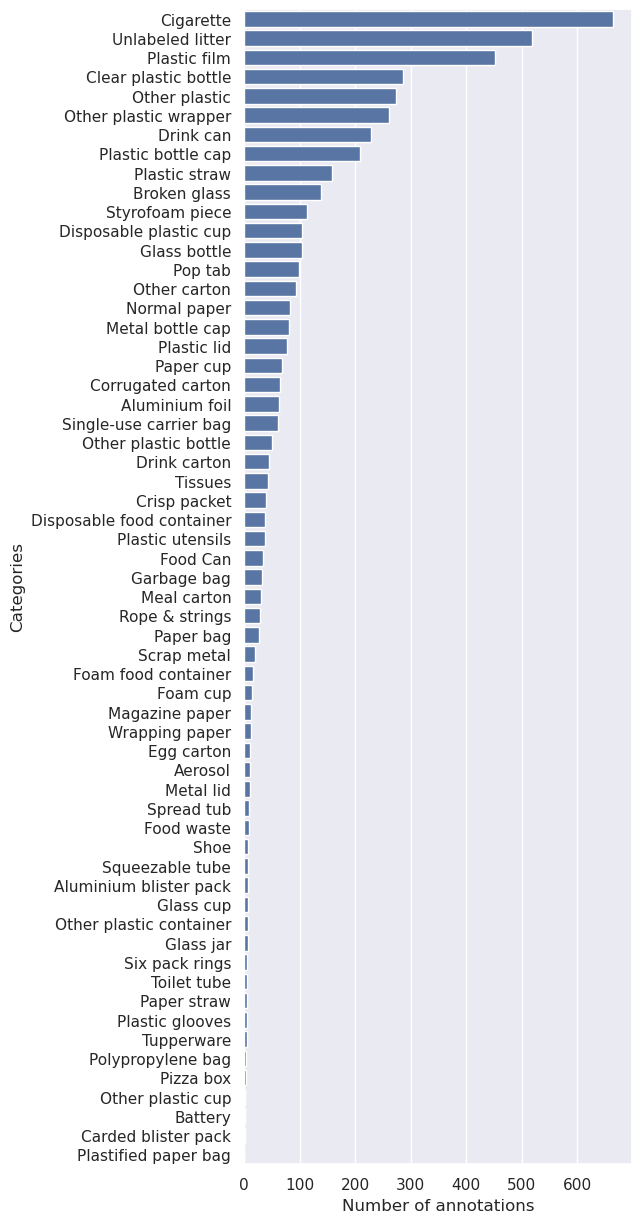

In [6]:
get_category_histogram_from_coco_obj(coco)

#### Let's print some of the images with thier annotations:

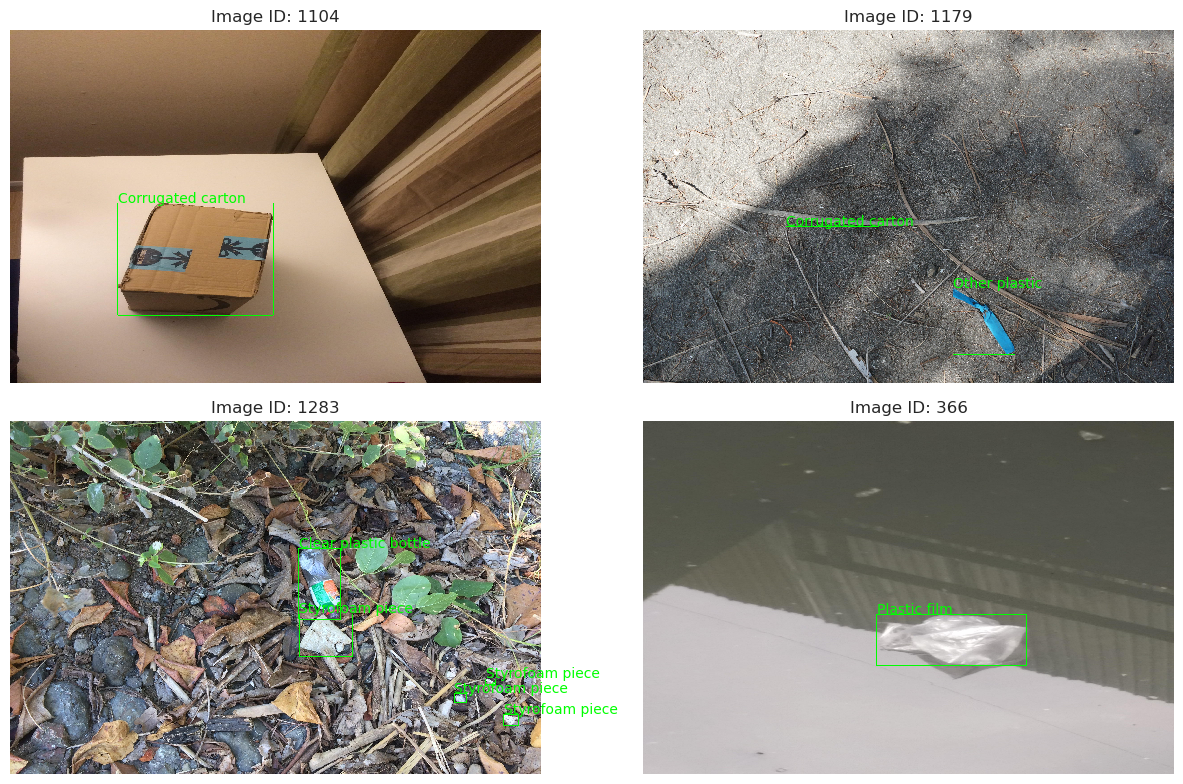

In [7]:
display_random_images_and_annotations(coco, dataset_path, num_images_to_display=4, rows=2, cols=2)

### Data Preparation:

In order to use the YOLOv8, we should transfer the TACO dataset into supported form by the YOLO model.

First we will create images and annotations dirs:

data_path = os.getcwd() + "/project/data"
images_path = os.path.join(data_path, "images")
labels_path = os.path.join(data_path, "labels")

try:
    os.makedirs(images_path)
    os.makedirs(labels_path)
except FileExistsError as e:
    pass

Now, we will merge all of the 60 categories of the TACO dataset into this 7 categories:
- Glass
- Metals and Plastics
- Non-recyclable
- Other
- Paper
- Biological
- Unknown

new_categories_map = {
    'bio': ["Food waste"],
    'glass': ['Broken glass', 'Glass bottle', 'Glass jar', 'Glass cup'],
    'metals_and_plastics': ['Aerosol', 'Aluminium foil', 'Clear plastic bottle', 'Disposable food container', 'Disposable plastic cup',
                            'Drink can', 'Drink carton', 'Food Can', 'Food can', 'Metal bottle cap', 'Metal lid', 'Other plastic',
                            'Other plastic bottle', 'Other plastic container', 'Other plastic cup', 'Plastic Film', 'Plastic bottle cap',
                            'Plastic film', 'Plastic glooves', 'Plastic lid', 'Plastic straw', 'Plastic utensils', 'Polypropylene bag',
                            'Pop tab', 'Scrap metal', 'Single-use carrier bag', 'Six pack rings', 'Spread tub', 'Tupperware'],
    'non_recyclable': ['Aluminium blister pack', 'Carded blister pack', 'Cigarette', 'Crisp packet', 'Foam cup', 'Foam food container',
                       'Garbage bag', 'Meal carton', 'Meal carton', 'Other plastic wrapper', 'Paper cup',
                       'Paper straw', 'Pizza box', 'Plastified paper bag', 'Rope', 'Rope & strings', 'Shoe', 'Squeezable tube',
                       'Styrofoam piece', 'Tissues', 'Wrapping paper'],
    'other': ["Battery"],
    'paper': ["Corrugated carton","Egg carton","Toilet tube","Other carton", 'Magazine paper', "Normal paper", "Paper bag"],
    'unknown': ["Unlabeled litter"]
}

categories_idx = {key: idx for idx, key in enumerate(new_categories_map.keys())}
categories_inverted = {k: v for v in new_categories_map.keys() for k in new_categories_map[v]}
cat_names = {cat['id']: cat['name'] for cat in annotations['categories']}

Now we should convert the COCO (TACO) annotation format to the YOLO annotation format, which means converting the coor given by the TACO dataset, which represent the top left point of the box, to the center of the box.

for img in annotations['images']:
    img_h = img['height']
    img_w = img['width']

    img_file = os.path.join(dataset_path, img['file_name'])
    image_path = os.path.join(images_path, img_file.replace('/', '_'))
    label_path = os.path.join(labels_path, img_file.replace('/', '_').split('.')[0]+'.txt')

    shutil.copy(img_file, image_path)

    newfile = open(label_path, 'w')
    for ann in annotations['annotations']:
        if ann['image_id'] == img['id']:
            x_mid, y_mid, w, h = coco_to_yolo_fmt(ann) 
            cat_id = map_to_new_categories(ann['category_id'], cat_names, categories_inverted, categories_idx)

            newfile.write(f'{cat_id} {x_mid / img_w} {y_mid / img_h} {w / img_w} {h / img_h}\n')

    newfile.close()

Splitting our data into train, validation and test sets:

yolo_dataset_path = os.getcwd() + "/project/dataset"

splitfolders.ratio(data_path, output=yolo_dataset_path, seed=0, ratio=(.8, .1, .1))

Final step here is to create the yaml file that the YOLO will use:

output_yaml = os.getcwd() + '/project/results/dataset.yaml'

convert_taco_annotations_to_yaml(yolo_dataset_path, output_yaml, new_categories_map)

### Model Selection:
As we mentiond earlier, we chose to work with the YOLOv8 model for few reasons:
- YOLO is one of the most popular OD models with great performance
- YOLOv8 is the newest and best version of YOLO, provide the YOLOv8 Nano, which is weight less that 10MB
- It's pre-trained on the COCO dataset, which is similer to the TACO dataset - could give us better performance
- We actually used YOLO before in the HW assigments, so it won't be new to us


### Model Evaluation:
Here we will train and evaluate different configuration of the YOLOv8 (nano). <br>
As we saw, we will train on 80% of the TACO dataset and use 10% for validation. <br>
The last 10% of the dataset will be used to evaluate are results: <br>
So in order to evaluate the models, we will use mAP - mean Average Precision, as it's the most popular metric in computer vision and object detection tasks. <br>
It measures the accuracy by considering the precision and recall at defferent thersholds of Intersection over Union (IoU). <br>
We will look at two metrics: <br>
- mAP50: Means that the mAP is calculated using predicted bounding box overlaps with the ground truth bounding box by at least 50%
- mAP50-95: Like mAP50 but the mAP is calculated over a range of IoU thresholds from 50% to 95%

### Model configurations:
We will test few configuration fo the YOLOv8, in order to gain the best performance.


#### Default model:
Here we will train the YOLOv8 from scratch on our data, while using the default parameters:
- epochs: 100
- batch: 16
- optimizer: SGD
- dropout: 0.0
- lr: 0.01
- weight_decay: 0.0005

In [8]:
output_yaml = os.getcwd() + '/project/results/dataset.yaml'

def_model = get_trained_model("default_yolov8", "Default Model", output_yaml, {"epochs": 100})

Cached Default Model model was found!


Default model Train Results:

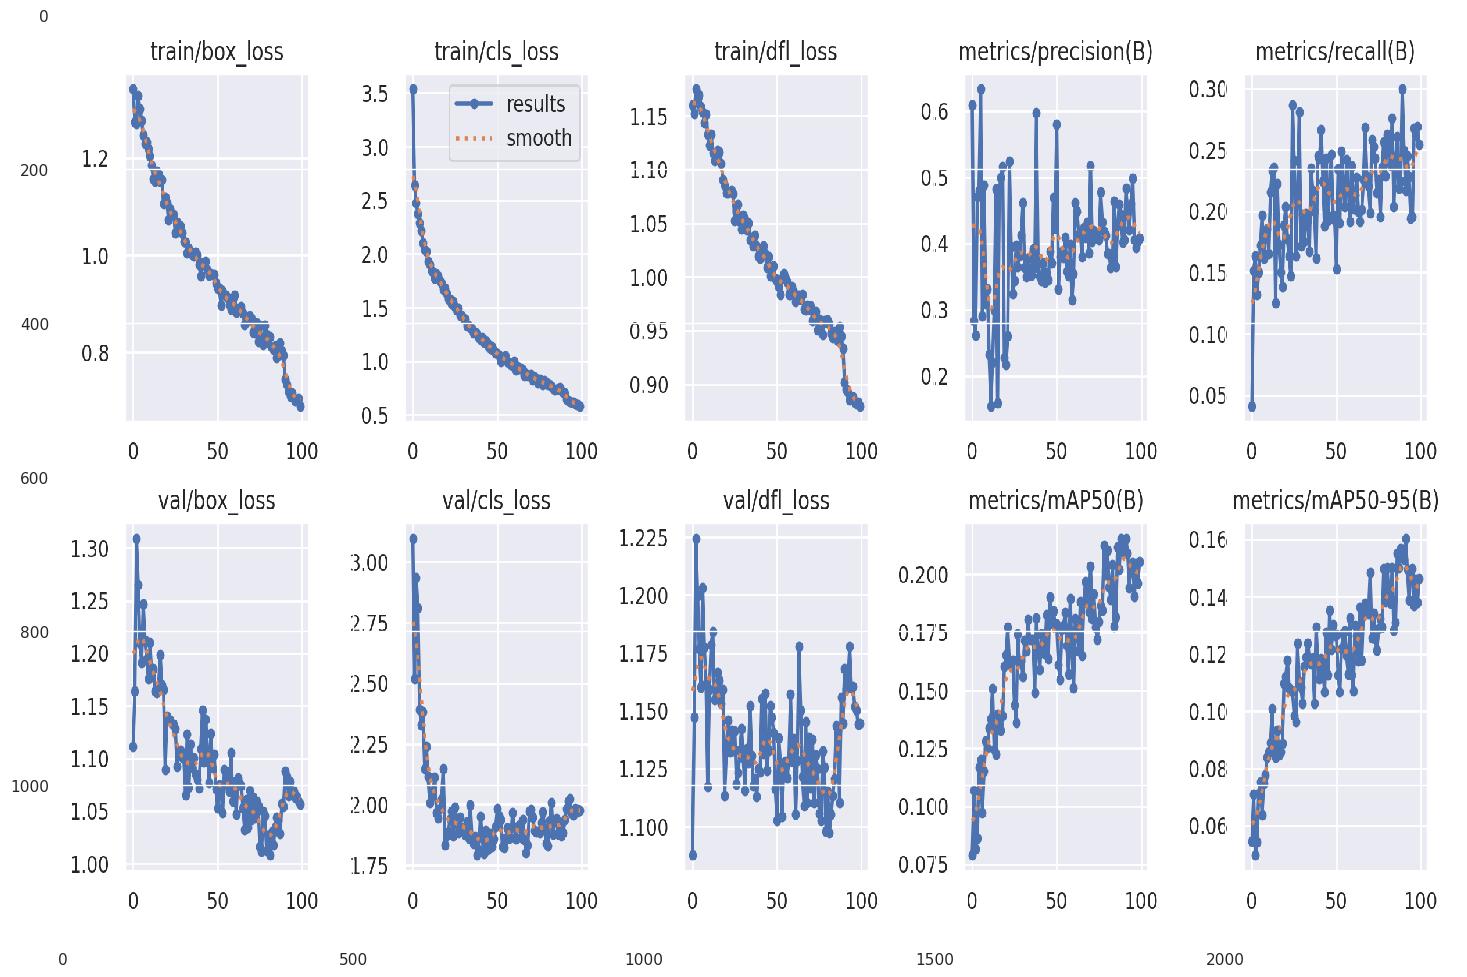

In [9]:
img = Image.open(os.getcwd() + '/project/results/default_yolov8/results.png')
plt.figure(figsize = (18,12))
plt.imshow(img, interpolation='nearest', aspect='auto')

Default model validation results:

In [10]:
def_model_res_dict = get_model_res_dict("default_yolov8", "Default", def_model)

print(f'mAP50-95 score: {def_model_res_dict["mAP50-95"]}')
print(f'mAP50 score: {def_model_res_dict["mAP50"]}')

Cached Default model val results found!
mAP50-95 score: 0.15854027305917887
mAP50 score: 0.21233590691226342


#### Pre-Trained Default model:
Same as the model above, but it major change - we will used the weights of the pre-trained model on the COCO dataset (Transfer Learning). <br>
This means that instead of initialise the weights to random values at the begininig, we will initiale them to the <br>
weights that achived in the training the yolov8 model on the COCO dataset.

- epochs: 100
- batch: 16
- optimizer: SGD
- dropout: 0.0
- lr: 0.01
- weight_decay: 0.0005

In [11]:
pt_def_model = get_trained_model("pt_default_yolov8", "Pre-trained Default Model", output_yaml, {"pretrained": True, "epochs": 100})

Cached Pre-trained Default Model model was found!


Pre-Trained Default model Train Results:

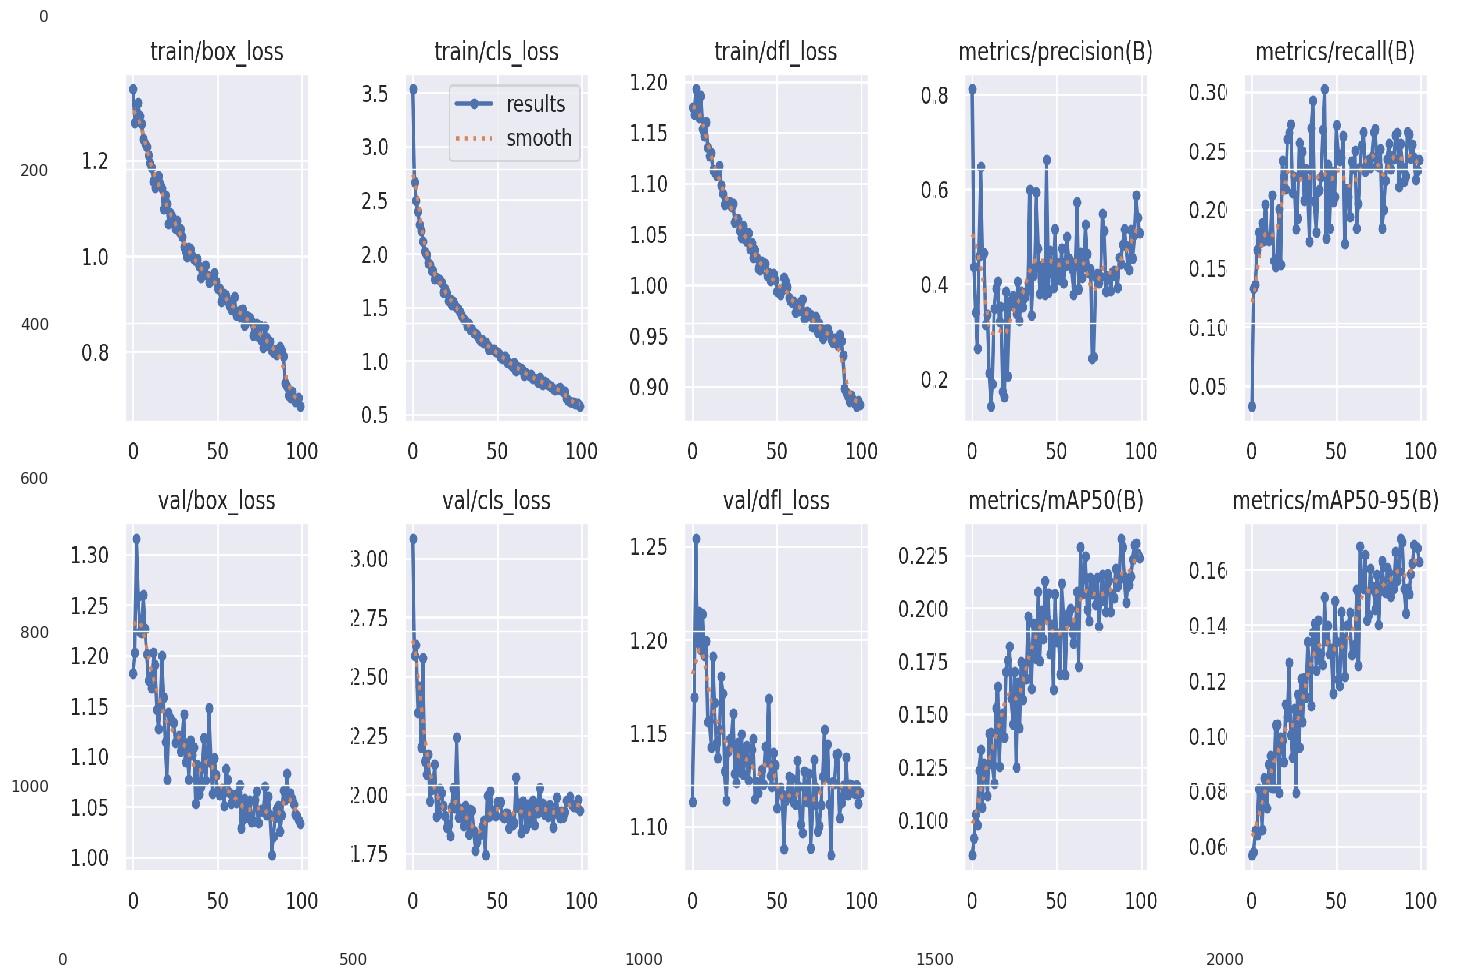

In [12]:
img = Image.open(os.getcwd() + '/project/results/pt_default_yolov8/results.png')
plt.figure(figsize = (18,12))
plt.imshow(img, interpolation='nearest', aspect='auto')

Pre-Trained Default model validation results:

In [13]:
pt_def_model_res_dict = get_model_res_dict("pt_default_yolov8", "Pre-trained Default", pt_def_model)

print(f'mAP50-95 score: {pt_def_model_res_dict["mAP50-95"]}')
print(f'mAP50 score: {pt_def_model_res_dict["mAP50"]}')

Cached Pre-trained Default model val results found!
mAP50-95 score: 0.16702592641321543
mAP50 score: 0.2306630318483827


#### Comparison between the Pre-trained Default model and the Regular Default model:
As one would expect, the Pre-trained model much performed better - 5-10% more precition! <br>
This is due to the fact that it initial the weights of the model using the trained COCO weights as we mention earlier.

In [14]:
print(f'Default model mAP50-95 score: {def_model_res_dict["mAP50-95"]}')
print(f'Pre-trained Default model mAP50-95 score: {pt_def_model_res_dict["mAP50-95"]}\n')

print(f'Default model mAP50 score: {def_model_res_dict["mAP50"]}')
print(f'Pre-trained Default model mAP50 score: {pt_def_model_res_dict["mAP50"]}')

Default model mAP50-95 score: 0.15854027305917887
Pre-trained Default model mAP50-95 score: 0.16702592641321543

Default model mAP50 score: 0.21233590691226342
Pre-trained Default model mAP50 score: 0.2306630318483827


Therefore, from now on, we will use only the pre-trained version of the model. <br> <br>

In mane cases, only changing the optimizer to mre complex one is significant.
#### Pre-trained Adam model:
As we saw throughout the course, the Adam optimizer perform much better the SGD in many cases:
- epochs: 100
- batch: 16
- optimizer: Adam
- dropout: 0.0
- lr: 0.01
- momentum (beta1): 0.9
- beta2: 0.999
- weight_decay: 0.0005

In [15]:
pt_adam_model = get_trained_model("pt_adam_yolov8", "Pre-trained Adam Model", output_yaml, {"pretrained": True, "optimizer": "Adam", "epochs": 100, "momentum": 0.9})

Cached Pre-trained Adam Model model was found!


Pre-Trained Adam model Train Results:

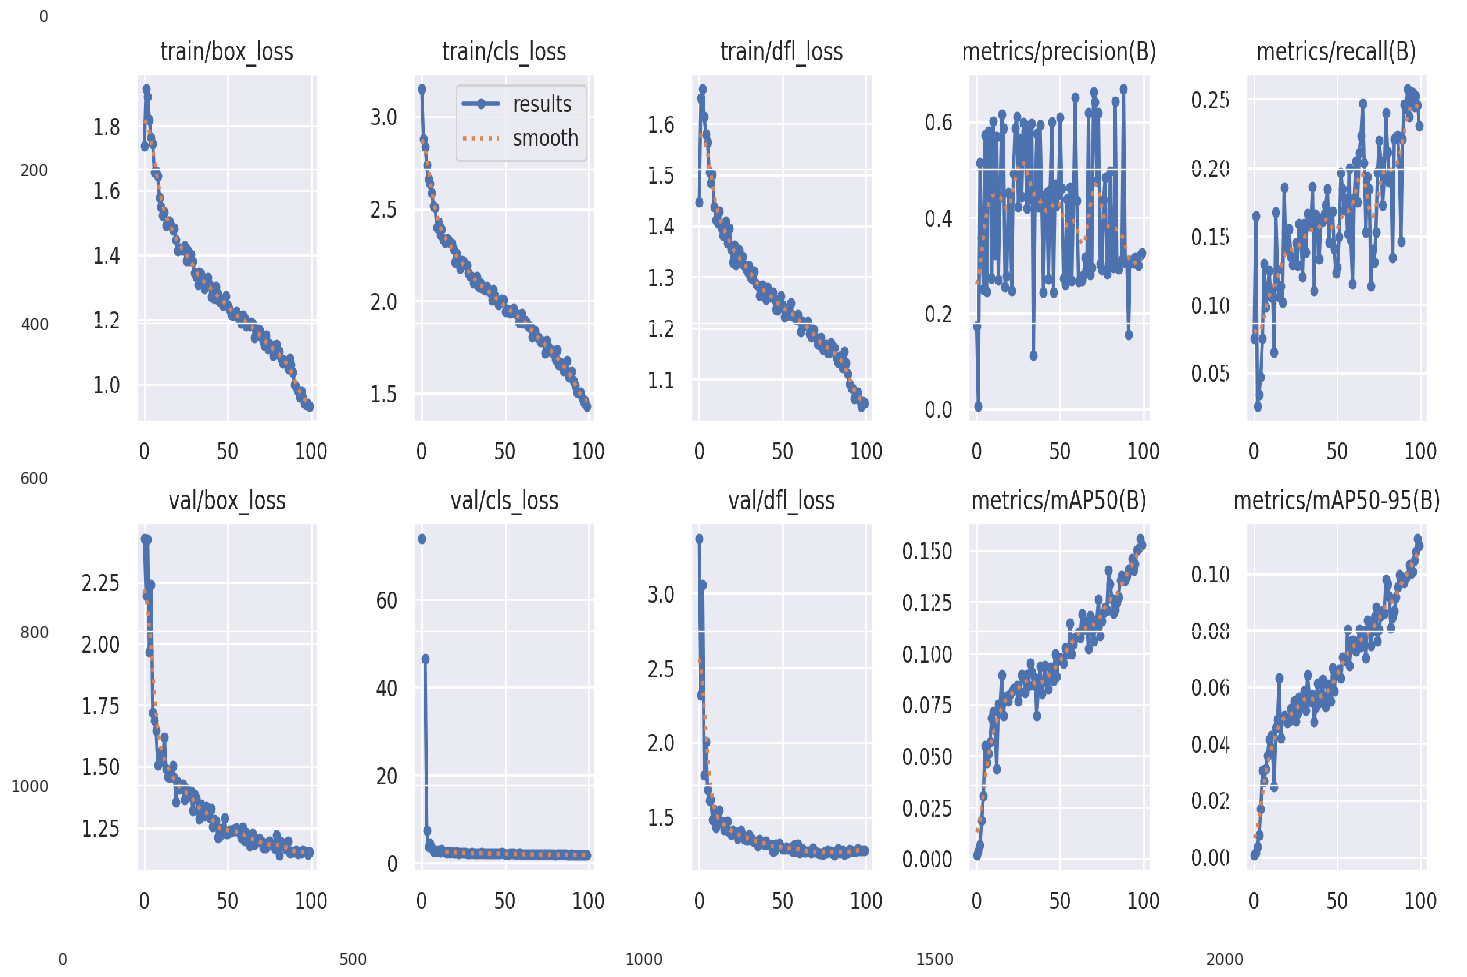

In [16]:
img = Image.open(os.getcwd() + '/project/results/pt_adam_yolov8/results.png')
plt.figure(figsize = (18,12))
plt.imshow(img, interpolation='nearest', aspect='auto')

Pre-Trained Adam model validation test results:

#### Pre-trained AdamW model:
Same as Adam, but the AdamW, uses the weight decay only to the gradient term (while the Adam uses it for the velocity too).
- epochs: 100
- batch: 16
- optimizer: AdamW
- dropout: 0.0
- lr: 0.01
- momentum (beta1): 0.9
- beta2: 0.999
- weight_decay: 0.0005

In [17]:
pt_adamw_model = get_trained_model("pt_adamw_yolov8", "Pre-trained AdamW Model", output_yaml, {"pretrained": True, "optimizer": "AdamW", "epochs": 100, "momentum": 0.9})

Cached Pre-trained AdamW Model model was found!


Pre-Trained Adam model validation training results:

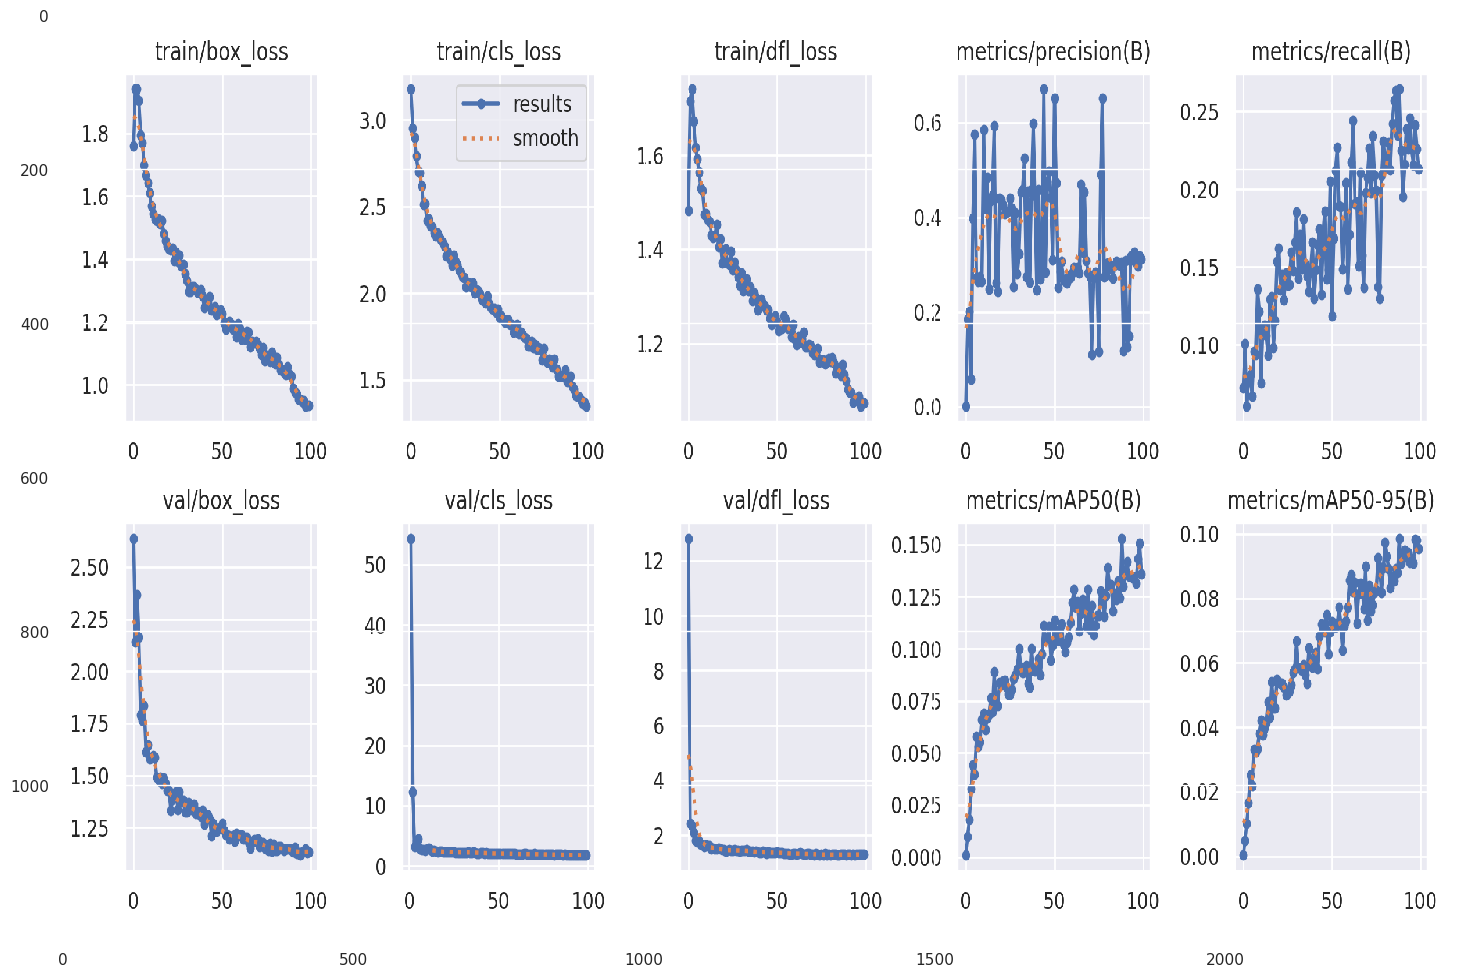

In [18]:
img = Image.open(os.getcwd() + '/project/results/pt_adamw_yolov8/results.png')
plt.figure(figsize = (18,12))
plt.imshow(img, interpolation='nearest', aspect='auto')

#### Comparison between the different optimizers:

In [19]:
pt_def_model_res_dict = get_model_res_dict("pt_default_yolov8", "Pre-trained Default", pt_def_model) # SGD
pt_adam_model_res_dict = get_model_res_dict("pt_adam_yolov8", "Pre-trained Adam", pt_adam_model)
pt_adamw_model_res_dict = get_model_res_dict("pt_adamw_yolov8", "Pre-trained AdamW", pt_adamw_model)

Cached Pre-trained Default model val results found!
Cached Pre-trained Adam model val results found!
Cached Pre-trained AdamW model val results found!


Contorary to our belefis, the SGD actually get better results than Adam and AdamW!
Worth to mention that both Adam and AdamW seems much more stable across the training, and probably will reach
same accuracy as the SGD one, but with more ephocs.

Therefore, we will prefer to use the SGD optimizer from now on...

In [20]:
print(f'Pre-trained AdamW model mAP50-95 score: {pt_adamw_model_res_dict["mAP50-95"]}')
print(f'Pre-trained Adam model mAP50-95 score: {pt_adam_model_res_dict["mAP50-95"]}')
print(f'Pre-trained SGD model mAP50-95 score: {pt_def_model_res_dict["mAP50-95"]}\n')

print(f'Pre-trained AdamW model mAP50 score: {pt_adamw_model_res_dict["mAP50"]}')
print(f'Pre-trained Adam model mAP50 score: {pt_adam_model_res_dict["mAP50"]}')
print(f'Pre-trained SGD model mAP50 score: {pt_def_model_res_dict["mAP50"]}')

Pre-trained AdamW model mAP50-95 score: 0.09848894799527154
Pre-trained Adam model mAP50-95 score: 0.11270649396357067
Pre-trained SGD model mAP50-95 score: 0.16702592641321543

Pre-trained AdamW model mAP50 score: 0.15306506870189987
Pre-trained Adam model mAP50 score: 0.1550572882586176
Pre-trained SGD model mAP50 score: 0.2306630318483827


# Hyperparameter Tuning for the optimal LR and Batch Size:

Let's tune the hyperparameters LR and Batch size:
- LR: we will test 3 different valeus of learning rates: 0.005, 0.01, 0.05. We chose those values as emprical tests suggested.
- Batch size: also here we will test 3 different valeus of batch sizes: 4, 8, 16. <br>
  We chose those values of the batch size since we wanted valeus that theyre power-of-two, and values bigger than 16 (32 and so on) will result VRAM mem exhust.
  Also batch size of 2 might be too small and lead to noisy grad.

In [21]:
from sklearn.model_selection import ParameterGrid

lr0 = [0.008, 0.01, 0.03]
batch = [4, 8, 16]

# Set up the search space
search_space = {'lr0': lr0, 'batch': batch}

# Create parameter grid
parameter_grid = ParameterGrid(search_space)

results = []
# Train and evaluate the model for each combination of hyperparameters
idx = 0
for parameters in parameter_grid:
    lr0 = parameters['lr0']
    batch = parameters['batch']
    model = get_trained_model("hp_search_yolov8" + str(idx), "HP search model", output_yaml, {"pretrained": True, "optimizer": "SGD", "epochs": 2, "lr0": lr0, "batch": batch})
    results.append([get_model_res_dict("hp_search_yolov8" + str(idx), "HP search model", model), lr0, batch]) 
    idx += 1


Cached HP search model model was found!
Cached HP search model model val results found!
Cached HP search model model was found!
Cached HP search model model val results found!
Cached HP search model model was found!
Cached HP search model model val results found!
Cached HP search model model was found!
Cached HP search model model val results found!
Cached HP search model model was found!
Cached HP search model model val results found!
Cached HP search model model was found!
Cached HP search model model val results found!
Cached HP search model model was found!
Cached HP search model model val results found!
Cached HP search model model was found!
Cached HP search model model val results found!
Cached HP search model model was found!
Cached HP search model model val results found!


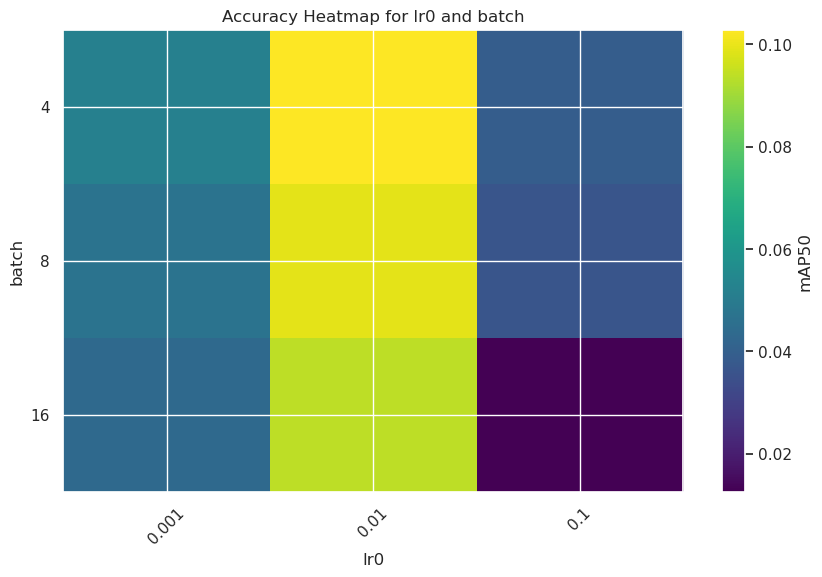

In [22]:
plot_heat_map(results, "mAP50", "lr0", "batch")